# Libraries

In [1]:
import pandas as pd
import re

# Data Exploration

In [2]:
df = pd.read_csv('/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv')

In [3]:
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
df.isnull().sum()

email    1
label    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [6]:
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

# Data Preprocessing

###  Remove missing values

In [7]:
# Identify the row with the missing email
missing_email_index = df[df['email'].isnull()].index

# Drop the row
df = df.drop(missing_email_index)

### Balancing Dataset

In [8]:
# Separate spam and not spam messages
spam_df = df[df['label'] == 1]
not_spam_df = df[df['label'] == 0]

### Undersampling Not Spam Message

In [9]:
# Randomly sample 500 not spam messages
not_spam_sampled_df = not_spam_df.sample(n=500, random_state=42)

### Combining Balanced Dataset

In [10]:
# Concatenate the spam messages with the sampled not spam messages
balanced_df = pd.concat([spam_df, not_spam_sampled_df])

In [11]:
# Shuffle the dataset to mix spam and not spam messages
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

### List of Stop words

In [12]:
stop_words = set([
    'the', 'is', 'in', 'and', 'to', 'of', 'a', 'with', 'that', 'this', 'for',
    'on', 'it', 'as', 'are', 'at', 'be', 'by', 'from', 'or', 'an', 'was', 'were', 'but', 'not'
])

### Preprocessing

In [13]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [14]:
# Apply preprocessing to the 'email' column
balanced_df['tokens'] = balanced_df['email'].apply(preprocess_text)

In [15]:
# View the first few tokenized emails
balanced_df[['email', 'tokens']].head()

,email,tokens
0,financial power you can depend on very compet...,"[financial, power, you, can, depend, very, com..."
1,url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...,"[url, url, date, number, number, numbertnumber..."
2,important information the new domain names are...,"[important, information, new, domain, names, f..."
3,take control of your computer with this top o...,"[take, control, your, computer, top, line, sof..."
4,url URL date not supplied i feel so tremendous...,"[url, url, date, supplied, i, feel, so, tremen..."


### Prepraring datset for Word2Vec

In [16]:
corpus = balanced_df['tokens'].tolist()

In [17]:
# Print the first email's tokens
print(corpus[0])

['financial', 'power', 'you', 'can', 'depend', 'very', 'competitive', 'rates', 'guaranteed', 'number', 'years', 'let', 'aig', 's', 'annuity', 'portfolio', 'work', 'you', 'm', 'best', 'company', 'superior', 'standard', 'poor', 's', 'corp', 'aa', 'very', 'strong', 'fitch', 'aa', 'very', 'strong', 'moody', 's', 'investors', 'service', 'aanumber', 'excellent', 'call', 'today', 'more', 'information', 'number', 'number', 'number', 'please', 'fill', 'out', 'form', 'below', 'more', 'information', 'name', 'e', 'mail', 'phone', 'city', 'state', 'aig', 'annuity', 'insurance', 'company', 'we', 'don', 't', 'want', 'anyone', 'receive', 'our', 'mailings', 'who', 'does', 'wish', 'receive', 'them', 'professional', 'communication', 'sent', 'insurance', 'professionals', 'removed', 'mailing', 'list', 'do', 'reply', 'message', 'instead', 'go', 'here', 'url', 'url', 'legal', 'notice', 'url']


# Word2Vec Implementation

### Build Vocabulary

In [18]:
# Extract all unique words from the corpus
vocabulary = set(word for tokens in corpus for word in tokens)
vocab_size = len(vocabulary)
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 21448


In [19]:
# Calculate word frequencies
word_counts = {}
for tokens in corpus:
    for word in tokens:
        word_counts[word] = word_counts.get(word, 0) + 1

### Handling Rare Words

In [20]:
# Remove rare words from the vocabulary
min_count = 3
vocabulary = set(word for word, count in word_counts.items() if count >= min_count)
vocab_size = len(vocabulary)
print(f"Reduced Vocabulary Size: {vocab_size}")

# Rebuild word mappings and reinitialize embeddings
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

Reduced Vocabulary Size: 7080


In [21]:
# After creating the vocabulary and word2idx, update the corpus
filtered_corpus = []
for tokens in corpus:
    filtered_tokens = [word for word in tokens if word in vocabulary]
    if filtered_tokens:  # Ensure the sentence is not empty
        filtered_corpus.append(filtered_tokens)

### Initializing Word Embeddings

In [22]:
import numpy as np

embedding_size = 10  # As specified in the assignment

# Initialize input and output embedding matrices with small random values
W_in = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_size))
W_out = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_size))
# W_in = np.random.uniform(-0.5/embedding_size, 0.5/embedding_size, (vocab_size, embedding_size))
# W_out = np.random.uniform(-0.5/embedding_size, 0.5/embedding_size, (vocab_size, embedding_size))

### Hyperparameters

In [23]:
window_size = 2
K = 3
epochs = 20
initial_alpha = 0.005  # Initial learning rate
decay = 0.1  # Learning rate decay factor
lambda_reg = 0.01  # Regularization strength
# alpha = initial_alpha / (1 + 0.01 * epoch)  # Decay factor

### Training Data

In [24]:
total_count = sum(word_counts.values())

# Calculate the probabilities for negative sampling
import math

# Calculate probabilities raised to the 3/4 power
word_probs = {}
for word in vocabulary:
    count = word_counts[word]
    word_probs[word] = math.pow(count / total_count, 0.75)

# Normalize the probabilities
total_prob = sum(word_probs.values())
word_probs = {word: prob / total_prob for word, prob in word_probs.items()}

# Create a list of words and their cumulative probabilities for sampling
words_list = list(word_probs.keys())
probs_list = [word_probs[word] for word in words_list]
cumulative_probs = np.cumsum(probs_list)

### Negative Sample Function

In [25]:
def negative_sampling(target_word_idx, K):
    negative_sample_indices = []
    while len(negative_sample_indices) < K:
        rand_prob = np.random.rand()
        word_idx = np.searchsorted(cumulative_probs, rand_prob)
        if word_idx != target_word_idx and word_idx not in negative_sample_indices:
            negative_sample_indices.append(word_idx)
    return negative_sample_indices

### Training Loop

In [26]:
def sigmoid(x):
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
    

def train_on_pair(pos_pair, neg_sample_indices, W_in, W_out, alpha):
    max_norm = 1.0  # Reduced gradient clipping threshold

    target_idx, context_idx = pos_pair

    # Get embeddings
    v_w = W_in[target_idx]
    v_c = W_out[context_idx]

    # Positive sample
    score = np.dot(v_w, v_c)
    sigmoid_score = sigmoid(score)
    loss = -np.log(sigmoid_score + 1e-10)

    # Gradients from positive sample
    grad_v_w = (sigmoid_score - 1) * v_c
    grad_v_c = (sigmoid_score - 1) * v_w

    # Negative samples
    for neg_idx in neg_sample_indices:
        v_neg = W_out[neg_idx]
        score_neg = np.dot(v_w, v_neg)
        sigmoid_neg = sigmoid(score_neg)
        loss += -np.log(1 - sigmoid_neg + 1e-10)

        grad_neg = sigmoid_neg
        grad_v_w += grad_neg * v_neg
        grad_v_neg = grad_neg * v_w

        # Regularize and clip grad_v_neg
        grad_v_neg += lambda_reg * v_neg
        grad_v_neg = np.clip(grad_v_neg, -max_norm, max_norm)

        # Update negative sample embeddings
        W_out[neg_idx] -= alpha * grad_v_neg

    # Add regularization to gradients
    grad_v_w += lambda_reg * v_w
    grad_v_c += lambda_reg * v_c

    # Gradient clipping
    grad_v_w = np.clip(grad_v_w, -max_norm, max_norm)
    grad_v_c = np.clip(grad_v_c, -max_norm, max_norm)

    # Update embeddings
    W_in[target_idx] -= alpha * grad_v_w
    W_out[context_idx] -= alpha * grad_v_c

    # After updating W_in and W_out in train_on_pair
    W_in[target_idx] = np.clip(W_in[target_idx], -max_norm, max_norm)
    W_out[context_idx] = np.clip(W_out[context_idx], -max_norm, max_norm)


    return loss

In [27]:
import numpy as np

# Calculate total word counts
total_words = sum(word_counts.values())

# Compute word frequencies
word_freqs = {word: count / total_words for word, count in word_counts.items()}

# Define the threshold
t = 1e-4

# Calculate the probability of keeping each word
word_keep_probs = {word: min(1.0, np.sqrt(t / freq)) for word, freq in word_freqs.items()}

# Apply subsampling
subsampled_corpus = []
for sentence in filtered_corpus:
    new_sentence = [word for word in sentence if np.random.rand() < word_keep_probs.get(word, 1.0)]
    if len(new_sentence) > 1:
        subsampled_corpus.append(new_sentence)

In [28]:
import random

losses = []

# Training Loop
for epoch in range(epochs):
    # Adjust the learning rate with decay
    alpha = initial_alpha / (1 + decay * epoch)
    #alpha = initial_alpha * (decay ** epoch)
    total_loss = 0
    num_pairs = 0
    random.shuffle(subsampled_corpus)
    for sentence in subsampled_corpus:
        sentence_length = len(sentence)
        for i, target_word in enumerate(sentence):
            target_word_idx = word2idx[target_word]
            # Dynamic context window
            dynamic_window = random.randint(1, window_size)
            start = max(0, i - dynamic_window)
            end = min(sentence_length, i + dynamic_window + 1)
            context_words = [sentence[j] for j in range(start, end) if j != i]
            for context_word in context_words:
                context_word_idx = word2idx[context_word]
                pos_pair = (target_word_idx, context_word_idx)
                neg_sample_indices = negative_sampling(target_word_idx, K)
                loss = train_on_pair(pos_pair, neg_sample_indices, W_in, W_out, alpha)
                total_loss += loss
                num_pairs += 1
    average_loss = total_loss / num_pairs
    print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss}, Average Loss: {average_loss}")
    losses.append(average_loss)

    # Compute and print embedding norms
    embedding_norm_in = np.linalg.norm(W_in)
    embedding_norm_out = np.linalg.norm(W_out)
    print(f"Embedding Norms - W_in: {embedding_norm_in}, W_out: {embedding_norm_out}")

Epoch 1/20, Total Loss: 756370.2994828305, Average Loss: 2.7725879095274997
Embedding Norms - W_in: 1.5328045050039207, W_out: 1.5264771689047587
Epoch 2/20, Total Loss: 757215.0743803859, Average Loss: 2.7725847444248646
Embedding Norms - W_in: 1.533917970414581, W_out: 1.5199872311931941
Epoch 3/20, Total Loss: 756730.6587337652, Average Loss: 2.772577468302832
Embedding Norms - W_in: 1.5402735963078331, W_out: 1.5185067844364621
Epoch 4/20, Total Loss: 756358.1183288713, Average Loss: 2.772553420901868
Embedding Norms - W_in: 1.5622924506330709, W_out: 1.5301375174325724
Epoch 5/20, Total Loss: 756538.1336717921, Average Loss: 2.7724815617163676
Embedding Norms - W_in: 1.6259781375644191, W_out: 1.5753500369840385
Epoch 6/20, Total Loss: 757455.8010433159, Average Loss: 2.7722683823769185
Embedding Norms - W_in: 1.7944132542528497, W_out: 1.7060192289329323
Epoch 7/20, Total Loss: 754932.494992848, Average Loss: 2.771686235393552
Embedding Norms - W_in: 2.1774114672846583, W_out: 2.

### Validation Loss

In [29]:
from sklearn.model_selection import train_test_split

# Split the corpus
train_corpus, val_corpus = train_test_split(filtered_corpus, test_size=0.1, random_state=42)

# In your training loop, after each epoch
# Calculate validation loss
# Calculate validation loss
val_loss = 0
num_val_pairs = 0
for sentence in val_corpus:
    sentence_length = len(sentence)
    for i, target_word in enumerate(sentence):
        target_word_idx = word2idx[target_word]
        start = max(0, i - window_size)
        end = min(sentence_length, i + window_size + 1)
        context_words = [sentence[j] for j in range(start, end) if j != i]
        for context_word in context_words:
            context_word_idx = word2idx[context_word]
            # Compute loss without updating embeddings
            score = np.dot(W_in[target_word_idx], W_out[context_word_idx])
            sigmoid_score = sigmoid(score)
            val_loss += -np.log(sigmoid_score + 1e-10)
            num_val_pairs += 1

val_average_loss = val_loss / num_val_pairs
print(f"Validation Loss after Epoch {epoch + 1}: {val_average_loss}")

Validation Loss after Epoch 20: 1.1632438966824377


### Saving and Testing Embedding

In [30]:
# Save embeddings
# Create a dictionary mapping words to their embeddings
word_embeddings = {word: W_in[word2idx[word]] for word in vocabulary}

# Optionally, save the embeddings to a file
import pickle

with open('word_embeddings.pkl', 'wb') as f:
    pickle.dump(word_embeddings, f)

# Save vocabulary
with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)

# Save word2idx mapping
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

# Save idx2word mapping
with open('idx2word.pkl', 'wb') as f:
    pickle.dump(idx2word, f)

### Testing Embeddings

In [31]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Example: Find words most similar to a given word
def find_similar_words(word, word_embeddings, top_n=5):
    if word not in word_embeddings:
        print(f"Word '{word}' not in vocabulary.")
        return
    target_embedding = word_embeddings[word]
    similarities = {}
    for other_word, other_embedding in word_embeddings.items():
        if other_word != word:
            similarity = cosine_similarity(target_embedding, other_embedding)
            similarities[other_word] = similarity
    # Sort by similarity
    sorted_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_words[:top_n]

# Test with a word from your vocabulary
similar_words = find_similar_words('email', word_embeddings)
print(f"Words similar to 'email': {similar_words}")

Words similar to 'email': [('description', 0.9997452357823864), ('could', 0.9996923810264745), ('razor', 0.9996863524384821), ('time', 0.9996841980817166), ('free', 0.9996792415892908)]


In [32]:
from itertools import combinations

cosine_similarities = []
for vec1, vec2 in combinations(word_embeddings.values(), 2):
    similarity = cosine_similarity(vec1, vec2)
    cosine_similarities.append(similarity)

average_similarity = np.mean(cosine_similarities)
print(f"Average Cosine Similarity: {average_similarity}")

Average Cosine Similarity: 0.9858863969693685


### Visualization Training

In [33]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Convert embeddings to a matrix
# embedding_matrix = W_in  # or W_out

# # Perform PCA
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(embedding_matrix)

# # Plot the embeddings
# plt.figure(figsize=(12, 12))
# for i, word in enumerate(word_embeddings.keys()):
#     plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
#     plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
# plt.title('PCA of Word Embeddings')
# plt.show()

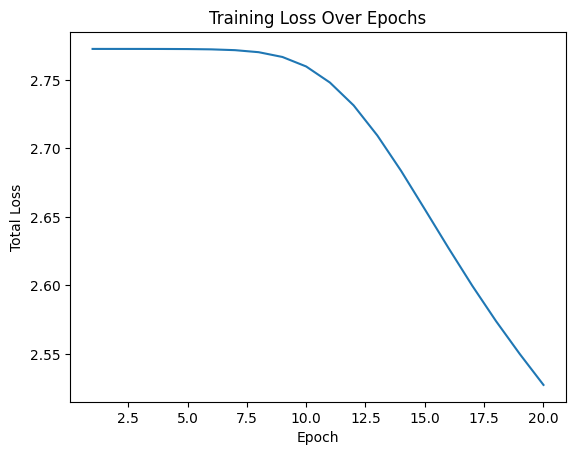

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Over Epochs')
plt.show()